In [3]:
%matplotlib inline

In [4]:
import logging, imp
import dataset
import utils
import proxynca
import net

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib
import matplotlib.image as mpimg
matplotlib.use('agg', warn=False, force=True)
import matplotlib.pyplot as plt
import time
import argparse
import torchvision

from __future__ import print_function, division
from torch.autograd import Variable

import os
import copy

from PIL import Image
import PIL.Image
import evaluation

plt.ion()  

/home/rachu/miniconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


## Visualize the data

The 'imshow' function averages the pixels over the image. Then I create a grid to visualize some of the images transformed and their class.

torch.FloatTensor
<class 'numpy.ndarray'>


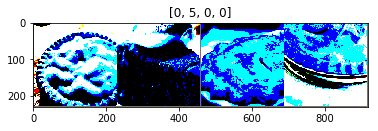

In [5]:
#To visualize the data
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #print(type(inp))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #Pause a bit so plots are updated

#DataLoader
dl_tr = torch.utils.data.DataLoader(
    dataset.Birds(
        root = 'upmc20', 
        labels = list(range(0, 10)), 
        transform = dataset.utils.make_transform()
    ),
    batch_size = 64,
    shuffle = True,
    num_workers = 16,
    drop_last = True,
    pin_memory = True
)

inputs, classes = next(iter(dl_tr))
print(inputs.type())
out = torchvision.utils.make_grid(inputs[0:4])
data_dir = 'upmc20' #Where I have the images saved

class_names = dl_tr.dataset.labels

imshow(out, title=[class_names[x] for x in classes[0:4]])

Shape of each image: (227, 227, 3)

## Make predictions

With the aid of an embedded model (embedded to 64 so each of the tensors have 64 characteristics) I find the closest 8 images to my instance and their classes.

In [6]:
def predict_batchwise(model, dataloader):
    with torch.no_grad():
        X, Y = zip(*[
            [x, y] for X, Y in dataloader #¿Itera por cada clase?
                for x, y in zip(
                    model(X.cuda()).cpu(), 
                    Y
                )
        ])
    return torch.stack(X), torch.stack(Y)

<class 'numpy.ndarray'>


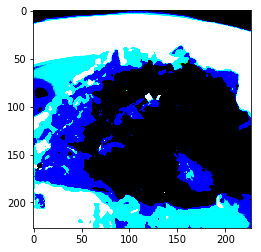

/home/rachu/miniconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


[809 645 365 133 814 317 846 848]
<class 'numpy.ndarray'>


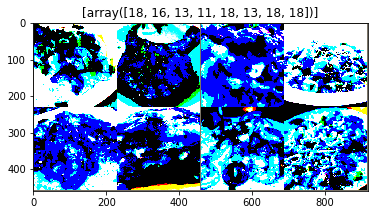

tensor([ 0.0023,  0.0175, -0.1435, -0.0747, -0.0768,  0.0160,  0.1909, -0.1453,
         0.2098, -0.2047, -0.2067,  0.1004,  0.0248,  0.0306,  0.1980,  0.0606,
        -0.2157, -0.1456, -0.0540,  0.1215,  0.0094,  0.1087, -0.0490, -0.0174,
        -0.0584,  0.0351,  0.1322, -0.0028, -0.0712, -0.0027, -0.0260, -0.0786,
         0.1360, -0.0337,  0.1082,  0.2225,  0.0819,  0.0682, -0.0747,  0.1569,
        -0.1435, -0.2535,  0.1662,  0.1100, -0.0584, -0.2370, -0.0838,  0.0244,
         0.1030, -0.0599,  0.1988,  0.0825,  0.0992,  0.0447, -0.0059,  0.1774,
        -0.1572,  0.1399, -0.0663,  0.1199, -0.1465,  0.1633,  0.0661, -0.2430])
tensor(18)
[18 16 13 11 18 13 18 18]


In [24]:
model = net.bn_inception()
net.embed(model, 64) #Models the size of the tensor
model.load_state_dict(torch.load('saved/saved_model.pth'))
model = model.cuda()
model.eval() #Fixes the model

dl_ev = torch.utils.data.DataLoader(
    dataset.Birds(
        root = 'upmc20', 
        labels = list(range(10, 20)),
        transform = dataset.utils.make_transform(is_train = False)
    ),
    batch_size = 64,
    shuffle = False,
    num_workers = 16,
    pin_memory = True
)


imshow(dl_ev.dataset[800][0]) #[1] contains the label of that image

X, T = predict_batchwise(model, dl_ev) #X has an embedded size
Y, indices = evaluation.assign_by_euclidian_at_k_indices(X, T, 8) #Solo me devuelve las clases

print(indices[800])
       
imshow(out, title=[Y[800]])

''' Imprimir los resultados a mano
print(X[800])
print(T[800])
print(Y[800])
'''